<a href="https://colab.research.google.com/github/GauravN03/Healthcare_Insurance_Analysis/blob/main/Employee_Turnover_Analytics_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np



In [2]:
df=pd.read_csv('/content/HR_comma_sep.csv')
df.head(10)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low
5,0.41,0.50,2,153,3,0,1,0,sales,low
6,0.10,0.77,6,247,4,0,1,0,sales,low
7,0.92,0.85,5,259,5,0,1,0,sales,low
8,0.89,1.00,5,224,5,0,1,0,sales,low
9,0.42,0.53,2,142,3,0,1,0,sales,low


In [7]:
var=df['satisfaction_level'].var()
var

0.061817200647087255

In [4]:
df['sales'].unique()

array(['sales', 'accounting', 'hr', 'technical', 'support', 'management',
       'IT', 'product_mng', 'marketing', 'RandD'], dtype=object)

In [5]:
df['salary'].unique()

array(['low', 'medium', 'high'], dtype=object)

In [6]:
df.isna().sum()

,0
satisfaction_level,0
last_evaluation,0
number_project,0
average_montly_hours,0
time_spend_company,0
Work_accident,0
left,0
promotion_last_5years,0
sales,0
salary,0


In [8]:
# Calculate correlations only for numeric columns
correlations = df.select_dtypes(include=np.number).corr()['left'].sort_values(ascending=False)
print(correlations)



left                     1.000000
time_spend_company       0.144822
average_montly_hours     0.071287
number_project           0.023787
last_evaluation          0.006567
promotion_last_5years   -0.061788
Work_accident           -0.154622
satisfaction_level      -0.388375
Name: left, dtype: float64


<ipython-input-9-d2f72edad3fa>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  left_employees['cluster'] = kmeans.labels_


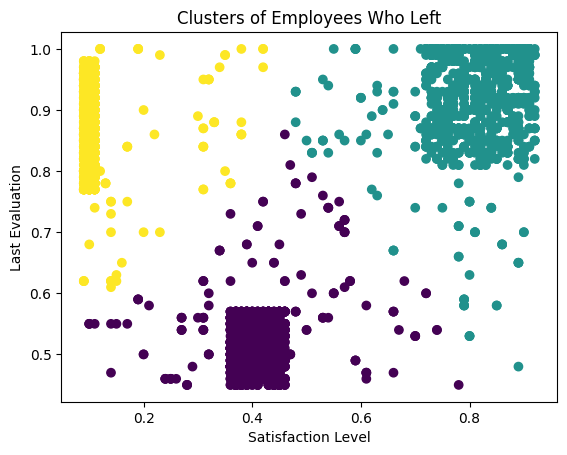

In [9]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Filter data for employees who left
left_employees = df[df['left'] == 1]

# Select relevant features and apply K-Means clustering
X = left_employees[['satisfaction_level', 'last_evaluation']]
kmeans = KMeans(n_clusters=3, random_state=0)  # Assuming 3 clusters
kmeans.fit(X)
left_employees['cluster'] = kmeans.labels_

# Visualize clusters
plt.scatter(left_employees['satisfaction_level'], left_employees['last_evaluation'], c=left_employees['cluster'])
plt.xlabel('Satisfaction Level')
plt.ylabel('Last Evaluation')
plt.title('Clusters of Employees Who Left')
plt.show()

In [10]:
#Apply smote
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Prepare data
X = df[['satisfaction_level', 'last_evaluation']]  # Features
y = df['left']  # Target variable

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Apply SMOTE
smote = SMOTE(random_state=0)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [11]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming X_train_resampled, y_train_resampled are from SMOTE
X = X_train_resampled
y = y_train_resampled

# Models to evaluate
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier()
}

# Perform k-fold cross-validation and evaluate
kfold = KFold(n_splits=5, shuffle=True, random_state=0)
scoring = ['accuracy', 'precision', 'recall', 'f1']

for model_name, model in models.items():
    print(f"Evaluating {model_name}:")
    for metric in scoring:
        scores = cross_val_score(model, X, y, cv=kfold, scoring=metric)
        print(f"  Average {metric}: {scores.mean()}")
    print("\n")



Evaluating Logistic Regression:
  Average accuracy: 0.7178773358917105
  Average precision: 0.7162974809374884
  Average recall: 0.7219354697942496
  Average f1: 0.7189923004420541


Evaluating Decision Tree:
  Average accuracy: 0.9354255147129191
  Average precision: 0.934793050793559
  Average recall: 0.9356978981524348
  Average f1: 0.9353810268069249


Evaluating Random Forest:
  Average accuracy: 0.9398072007159136
  Average precision: 0.9330434809084573
  Average recall: 0.9463155766228653
  Average f1: 0.9403162129076492




Logistic Regression Confusion Matrix:
[[2130  169]
 [ 522  179]]

Decision Tree Confusion Matrix:
[[2175  124]
 [ 117  584]]

Random Forest Confusion Matrix:
[[2171  128]
 [ 107  594]]



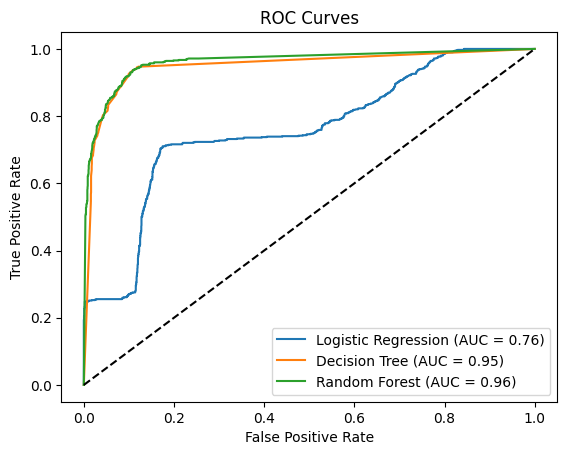

Recall is the preferred metric for employee retention as it prioritizes minimizing False Negatives (misclassifying employees who will leave as those who will stay).


In [12]:
from sklearn.metrics import roc_curve, auc, confusion_matrix
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_probs = model.predict_proba(X_test)[:, 1]

    # ROC/AUC and plot
    fpr, tpr, thresholds = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

    # Confusion matrix
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    print(f"{model_name} Confusion Matrix:\n{cm}\n")

# Plot ROC curves
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.show()

# Recall is more important for employee retention (minimize false negatives)
print("Recall is the preferred metric for employee retention as it prioritizes minimizing False Negatives (misclassifying employees who will leave as those who will stay).")
